# Database queries and loading imaging datasets

This notebook demonstrates some example imagingDB usecases for data that has already been uploaded to the dataset.
It will show you how to perform some simple queries in SQLAlchemy, as well as fetching the associated images.
It will also compare how long it takes to load the data from local storage vs S3.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import importlib
import os
import sys
import time

module_path = os.path.abspath(os.path.join('..'))
print(module_path)
if module_path not in sys.path:
    sys.path.append(module_path)
    
# Import both local and S3 storage
import imaging_db.database.db_operations as db_ops
import imaging_db.filestorage.s3_storage as s3_storage
import imaging_db.filestorage.local_storage as local_storage
import imaging_db.utils.db_utils as db_utils

/Users/jenny.folkesson/Code/imagingDB


Load database credentials file by providing the full path to the file. This is the JSON file containing database login information such as host, port, names of database, driver and user, as well as password.

In [2]:
credentials_filename = "/Users/jenny.folkesson/Code/db_credentials.json"
credentials_str = db_utils.get_connection_str(credentials_filename)

Now we can run some queries. Let's start with listing the names of existing tables

In [3]:
with db_ops.session_scope(credentials_str) as session:
    print(db_ops.Base.metadata.tables.keys())

dict_keys(['data_set', 'file_global', 'frames', 'frames_global'])


You can see the database schema in the [Readme](https://github.com/czbiohub/imagingDB), and you can see how the tables are defined in SQLAlchemy in imaging_db/database/
The main table [DataSet](https://github.com/czbiohub/imagingDB/blob/master/imaging_db/database/dataset.py) contains the unique identifier, a description, and it's also telling us if the file as been sliced into individual 2D frames or uploaded as is (uninspected file).

In [4]:
# Print three datasets with their properties
with db_ops.session_scope(credentials_str) as session:
    datasets = session.query(db_ops.DataSet)
    for d in datasets[2:5]:
        print(d.id)
        print(d.dataset_serial)
        print("Description:", d.description)
        print("Date/time:", d.date_time)
        print("Has this file been split into frames:", d.frames)
        print("Microscope:", d.microscope)
        print("Parent key:", d.parent_id)
        print("--------")

11
ISP-2018-06-01-00-00-00-0002
Description: New test ome tif
Date/time: 2018-06-01 00:00:00
Has this file been split into frames: True
Microscope: None
Parent key: None
--------
12
ISP-2018-06-01-00-00-00-0003
Description: Same as 002
Date/time: 2018-06-01 00:00:00
Has this file been split into frames: True
Microscope: None
Parent key: 11
--------
13
SMS-2018-07-03-18-35-00-0010
Description: Only 10 frames from each channel at position 0 from larger background corrected dataset
Date/time: 2018-07-03 18:35:00
Has this file been split into frames: True
Microscope: Birefringence
Parent key: None
--------


Next, let's print some of the fields for the first three files in FileGlobal.
[FileGlobal](https://github.com/czbiohub/imagingDB/blob/master/imaging_db/database/file_global.py) is the table which contains files that have been uploaded as is to storage. It has a one to one mapping with DataSet.

In [5]:
with db_ops.session_scope(credentials_str) as session:
    files = session.query(db_ops.FileGlobal)
    for f in files[:3]:
        # This table has a one to one mapping with Project so we can retrieve ID
        print(f.data_set.dataset_serial)
        print("Folder location in storage directory:", f.storage_dir)
        print(f.metadata_json)
        print("--------")

ML-2018-11-28-10-57-40-0002
Folder location in storage directory: raw_files/ML-2018-11-28-10-57-40-0002
{'file_origin': '/Volumes/dav/LibraryDatabase/Plate1_FACS/A1_ATL2_B_FACS.png'}
--------
ML-2018-11-28-10-57-47-0002
Folder location in storage directory: raw_files/ML-2018-11-28-10-57-47-0002
{'file_origin': '/Volumes/dav/LibraryDatabase/Plate1_FACS/A1_ATL2_B_FACS.png'}
--------
ML-2018-11-28-10-57-53-0002
Folder location in storage directory: raw_files/ML-2018-11-28-10-57-53-0002
{'file_origin': '/Volumes/dav/LibraryDatabase/Plate1_FACS/A1_ATL2_B_FACS.png'}
--------


[FramesGlobal](https://github.com/czbiohub/imagingDB/blob/master/imaging_db/database/frames_global.py) contains global information for a particular file that has been split into individual frames and their global metadata. It has a one to one mapping with DataSet. Here are the three entries corresponding to the DataSet entries above.

In [6]:
with db_ops.session_scope(credentials_str) as session:
    frames = session.query(db_ops.FramesGlobal)
    for f in frames[2:5]:
        print("Number of frames:", f.nbr_frames)
        print("Image width:", f.im_width)
        print("Image height:", f.im_height)
        print("z depth in stack:", f.nbr_slices)
        print("Number of channels:", f.nbr_channels)
        print("Number of time points:", f.nbr_timepoints)
        print("Number of positions (FOVs):", f.nbr_positions)
        print("Number of color channels:", f.im_colors)
        print("Bit depth:", f.bit_depth)
        print("Directory in storage (local and S3):", f.storage_dir)
        # This table has a one to one mapping with Project so we can retrieve ID
        print("Unique ID:", f.data_set.dataset_serial)
        # Not printing metadata, but it's a queryable json where all global information is stored
        print("--------")

Number of frames: 60
Image width: 1081
Image height: 1081
z depth in stack: 10
Number of channels: 6
Number of time points: 1
Number of positions (FOVs): 1
Number of color channels: 1
Bit depth: <class 'numpy.uint16'>
Directory in storage (local and S3): raw_frames/SMS-2018-07-03-18-35-00-0010
Unique ID: SMS-2018-07-03-18-35-00-0010
--------
Number of frames: 31590
Image width: 2048
Image height: 2048
z depth in stack: 26
Number of channels: 9
Number of time points: 1
Number of positions (FOVs): 135
Number of color channels: 1
Bit depth: uint16
Directory in storage (local and S3): raw_frames/SMS-2018-11-01-19-06-00-0001
Unique ID: SMS-2018-11-01-19-06-00-0001
--------
Number of frames: 72
Image width: 1024
Image height: 1024
z depth in stack: 36
Number of channels: 2
Number of time points: 1
Number of positions (FOVs): 1
Number of color channels: 1
Bit depth: uint16
Directory in storage (local and S3): raw_frames/ML-2018-11-06-09-49-00-0001
Unique ID: ML-2018-11-06-09-49-00-0001
------

Last but not least is [Frames](https://github.com/czbiohub/imagingDB/blob/master/imaging_db/database/frames.py), which is the table that contains specific information for each of the 2D frames summarized in FramesGlobal.
This table has a many to one mapping with FramesGlobal.

In [7]:
# print first 3 frames
with db_ops.session_scope(credentials_str) as session:
    frame_info = session.query(db_ops.Frames)
    for i in frame_info[0:3]:
        print(i.id)
        print("Channel index:", i.channel_idx)
        print("Slice (z) index:", i.slice_idx)
        print("Time index:", i.time_idx)
        print("Position index:", i.pos_idx)
        print("Channel name:", i.channel_name)
        print("File name:", i.file_name)
        # Since Frames has a many to one mapping to FramesGlobal, we can easily retrieve info from there
        print("Total number of frames in dataset:", i.frames_global.nbr_frames)
        # FramesGlobal in turn has a one to one mapping to DataSet, so from a Frame we can also access DataSet info:
        print("Project ID:", i.frames_global.data_set.dataset_serial)
        print("Sha256:", i.sha256)
        print("------------------------------------")

818
Channel index: 0
Slice (z) index: 1
Time index: 0
Position index: 1
Channel name: DAPI
File name: im_c000_z001_t000_p001.png
Total number of frames in dataset: 39
Project ID: ISP-2018-06-08-15-45-00-0001
Sha256: 951d91c5121e63b36f13b53d4e727df0bfa2d1fcb42caaf077ae526b3376828d
------------------------------------
820
Channel index: 0
Slice (z) index: 3
Time index: 0
Position index: 1
Channel name: DAPI
File name: im_c000_z003_t000_p001.png
Total number of frames in dataset: 39
Project ID: ISP-2018-06-08-15-45-00-0001
Sha256: deb5ee52e38300fed4986f2396465ba862abbaccab6862e58edbd06a3a18e313
------------------------------------
822
Channel index: 0
Slice (z) index: 5
Time index: 0
Position index: 1
Channel name: DAPI
File name: im_c000_z005_t000_p001.png
Total number of frames in dataset: 39
Project ID: ISP-2018-06-08-15-45-00-0001
Sha256: f9f776e82e16c5997f6b8aa071c5afce0a8a6d2c7257eefa13df6c871f8bca21
------------------------------------


Some other examples of queries:
Find all data sets which have been split into frames vs kept as unopened files.

In [8]:
with db_ops.session_scope(credentials_str) as session:
    datasets = session.query(db_ops.DataSet).filter(db_ops.DataSet.frames == True).all()
    print("Nbr datasets split into frames:", len(datasets))
    datasets = session.query(db_ops.DataSet).filter(db_ops.DataSet.frames == False).all()
    print("Nbr datasets kept as files:", len(datasets))

Nbr datasets split into frames: 8949
Nbr datasets kept as files: 8709


Get all unique channel names for data sets split into frames. If channel name is not accessible during the metadata extraction process it will be listed as None.

In [9]:
with db_ops.session_scope(credentials_str) as session:
    for value in session.query(db_ops.Frames.channel_name).distinct():
        print(value[0])

None
488
568
C
Orientation_y
Scattering
405
Transmission
Orientation
A
Cy5
DAPI
Orientation_x
G
Retardance
Cy3
T
FITC


Now let's get into joint queries. 

A typical usecase would be to retrieve frames from a known dataset ID.
In this example we only want to retrieve the images from a specific channel named FITC.

We can get this information by joining tables Frames, FramesGlobal, and DataSet.

Let's start off with just getting the first frame from a query.

In [10]:
dataset_identifier = "ISP-2018-06-08-15-45-00-0001"
channel_name = "FITC"

file_name = None
with db_ops.session_scope(credentials_str) as session:
    first_frame = session.query(db_ops.Frames) \
        .join(db_ops.FramesGlobal) \
        .join(db_ops.DataSet) \
        .filter(db_ops.DataSet.dataset_serial == dataset_identifier) \
        .filter(db_ops.Frames.channel_name == channel_name) \
        .first()

    storage_dir = first_frame.frames_global.storage_dir
    print(storage_dir)
    file_name = first_frame.file_name
    print(file_name)

raw_frames/ISP-2018-06-08-15-45-00-0001
im_c001_z000_t000_p001.png


Let's fetch it from S3 storage and plot it.

Load time: 0.51 seconds
Im uint16 (2048, 2048)


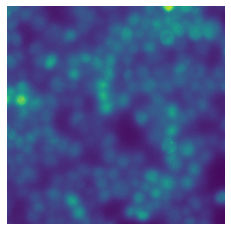

In [11]:
data_loader = s3_storage.S3Storage(storage_dir=storage_dir)

t0 = time.time()
im = data_loader.get_im(file_name)
print("Load time: {:.2f} seconds".format(time.time() - t0))
print("Im", im.dtype, im.shape)
plt.imshow(im)
plt.rcParams['figure.figsize'] = [10, 10]
plt.axis('off')
plt.show()

Load again but from local storage this time. Make sure you've mounted your local storage, and if it's not mounted to the default location you need to specify mount location.

In [12]:
data_loader = local_storage.LocalStorage(storage_dir=storage_dir)

t0 = time.time()
im = data_loader.get_im(file_name)
print("Load time: {:.2f} seconds".format(time.time() - t0))
print("Im", im.dtype, im.shape)

Load time: 0.81 seconds
Im uint16 (2048, 2048)


Here we do the same query but instead of fetching just the first result, we fetch all images from the FITC channel.

In [13]:
file_names = []
with db_ops.session_scope(credentials_str) as session:
    all_frames = session.query(db_ops.Frames) \
        .join(db_ops.FramesGlobal) \
        .join(db_ops.DataSet) \
        .filter(db_ops.DataSet.dataset_serial == dataset_identifier) \
        .filter(db_ops.Frames.channel_name == channel_name) \
        .order_by(db_ops.Frames.file_name) \
        .all()

    bit_depth = all_frames[0].frames_global.bit_depth
    print("Bit depth:", bit_depth)
    for f in all_frames:
        file_names.append(f.file_name)
        print(f.file_name)

Bit depth: uint16
im_c001_z000_t000_p001.png
im_c001_z001_t000_p001.png
im_c001_z002_t000_p001.png
im_c001_z003_t000_p001.png
im_c001_z004_t000_p001.png
im_c001_z005_t000_p001.png
im_c001_z006_t000_p001.png
im_c001_z007_t000_p001.png
im_c001_z008_t000_p001.png
im_c001_z009_t000_p001.png
im_c001_z010_t000_p001.png
im_c001_z011_t000_p001.png
im_c001_z012_t000_p001.png


Now we can fetch that data from storage. Plot the first image again.

In [14]:
data_loader = local_storage.LocalStorage(storage_dir=storage_dir)
t0 = time.time()
im_stack = data_loader.get_stack(file_names)
print("Load time: {:.2f} seconds".format(time.time() - t0))

print("Stack shape: {} and type: {}".format(im_stack.shape, im_stack.dtype))

Load time: 0.82 seconds
Stack shape: (2048, 2048, 13) and type: uint16


You can also use the class [DatabaseOperations](https://github.com/czbiohub/imagingDB/blob/master/imaging_db/database/db_operations.py) to retrieve metadata from a dataset, which you can then use to fetch whatever images you want to load.

In [15]:
db_inst = db_ops.DatabaseOperations(
    dataset_serial="ISP-2018-06-01-00-00-00-0002",
)
with db_ops.session_scope(credentials_str) as session:
    global_meta, frames_meta = db_inst.get_frames_meta(
        session=session,
        channels=(1,),
    )
    print("All global information about dataset:", global_meta)

All global information about dataset: {'storage_dir': 'raw_frames/ISP-2018-06-01-00-00-00-0002', 'nbr_frames': 26, 'im_width': 2048, 'im_height': 2048, 'nbr_slices': 13, 'nbr_channels': 2, 'im_colors': 1, 'nbr_timepoints': 1, 'nbr_positions': 1, 'bit_depth': 'uint16', 'metadata_json': {'IJMetadata': {'ROI': [0, 0, 2048, 2048], 'UUID': 'eede2dbf-80e0-4900-9a6a-ee28eb8ba5fc', 'Depth': 2, 'Width': 2048, 'Frames': 1, 'Height': 2048, 'IJType': 1, 'Prefix': 'ISP_293T_TFRC_blank_20180601_1', 'Slices': 13, 'Source': 'Micro-Manager', 'ChNames': ['DAPI', 'Cy3'], 'Comment': '', 'GridRow': 0, 'BitDepth': 16, 'ChColors': [-10066177, -205], 'Channels': 2, 'UserName': 'insituscope', 'Directory': 'C:\\Users\\InSituScope\\Desktop\\ISP-2018-06-01-001', 'PixelType': 'GRAY16', 'Positions': 6, 'TimeFirst': False, 'z-step_um': 0.7999999999999998, 'GridColumn': 0, 'Interval_ms': 0, 'PixelAspect': 1, 'SlicesFirst': True, 'ComputerName': 'BioEInSituTranscript1', 'PixelSize_um': 0, 'CameraTimeout': 20000, 'ChCo

In [16]:
# Print local metadata for one frame
print(frames_meta.iloc[0])

channel_idx                                                     1
slice_idx                                                       0
time_idx                                                        0
channel_name                                                  Cy3
file_name                              im_c001_z000_t000_p002.png
pos_idx                                                         2
sha256          954b534f321eae2f6e13f340653ac9f1801a234d6150ba...
Name: 0, dtype: object


In [17]:
# Get image stack from metadata
data_loader = local_storage.LocalStorage(storage_dir=global_meta["storage_dir"])
t0 = time.time()
im_stack, dim_order = data_loader.get_stack_from_meta(global_meta, frames_meta)
print("Time to load stack: {:.2f}".format(time.time() - t0))
print("Dimensions and order:", dim_order)
print(im_stack.shape)

Time to load stack: 1.46
Dimensions and order: XYZ
(2048, 2048, 13)


In [18]:
# When displaying too much output in a Jupyter Notebook you can run into a "IOPub data rate exceeded."
# You can uncomment this cell if you've increased you NotebookApp.iopub_data_rate_limit to significantly higher
# than default settings.

# import matplotlib.animation as animation
# from IPython.display import HTML


# # Plot a flythrough of the first channel
# fig = plt.figure()
# plt.rcParams['figure.figsize'] = [10, 10]
# plt.axis('off')

# frames = []
# for i in range(im_stack.shape[2]):
#     frame = plt.imshow(im_stack[:, :, i], animated=True)
#     frames.append([frame])

# anim = animation.ArtistAnimation(fig, frames)

# # Call function to display the animation
# HTML(anim.to_html5_video())

Here's another example fetching a small subset of data from a larger dataset. Find a dataset with kidney in description.

In [19]:
with db_ops.session_scope(credentials_str) as session:
    datasets = db_ops.get_datasets(
        session=session,
        search_dict={'description': 'kidney'}
    )
    print("Found {} datasets.".format(len(datasets)))
    dataset_serial = datasets[0].dataset_serial
    print("ID:", dataset_serial)
    print("Full description:", datasets[0].description)

Found 1 datasets.
ID: SMS-2018-11-01-19-06-00-0001
Full description: Registered kidney birefringence dataset


In [20]:
db_inst = db_ops.DatabaseOperations(
    dataset_serial=dataset_serial,
)
# Fetch a few z slices from two of the FOVs and channels
with db_ops.session_scope(credentials_str) as session:
    global_meta, frames_meta = db_inst.get_frames_meta(
        session=session,
        channels=('568', 'Transmission'),
        positions=(50, 60),
        slices=(11, 12, 13, 14, 15),
    )
    
# See how much data is in the dataset
print('Total nbr frames: {}'.format(global_meta['nbr_frames']))
print('Nbr FOVs: {}'.format(global_meta['nbr_positions']))
print('Nbr slices per FOV: {}'.format(global_meta['nbr_slices']))
print('Nbr channels: {}'.format(global_meta['nbr_channels']))
print('Nbr timepoints: {}'.format(global_meta['nbr_timepoints']))

Total nbr frames: 31590
Nbr FOVs: 135
Nbr slices per FOV: 26
Nbr channels: 9
Nbr timepoints: 1


In [24]:
# Load the images
data_loader = local_storage.LocalStorage(storage_dir=global_meta["storage_dir"])
t0 = time.time()
im_stack, dim_order = data_loader.get_stack_from_meta(global_meta, frames_meta)
print("Time to load stack: {:.2f}".format(time.time() - t0))
print("Dimensions and order: {} of stack with shape: {}".format(dim_order, im_stack.shape))

Time to load stack: 25.73
Dimensions and order: XYZCP of stack with shape: (2048, 2048, 5, 2, 2)


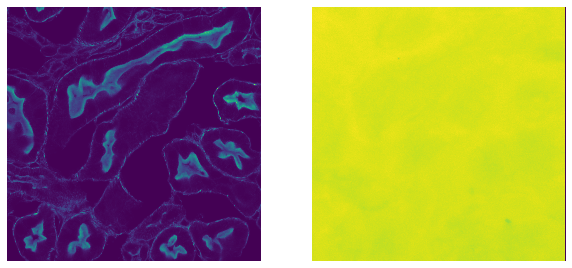

In [25]:
# Plot the center slice of each channel side by side
plt.subplot(121); plt.imshow(im_stack[:, :, 3, 0, 0])
plt.axis('off')
plt.subplot(122); plt.imshow(im_stack[:, :, 3, 1, 0])
plt.rcParams['figure.figsize'] = [10, 15]
plt.axis('off')
plt.show()